# LAB 8 - P2: Tattoo CNN
### Hecho por: Joshua Sancho y Steven Solís

## Librerías

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

## Entendimiento de los Datos

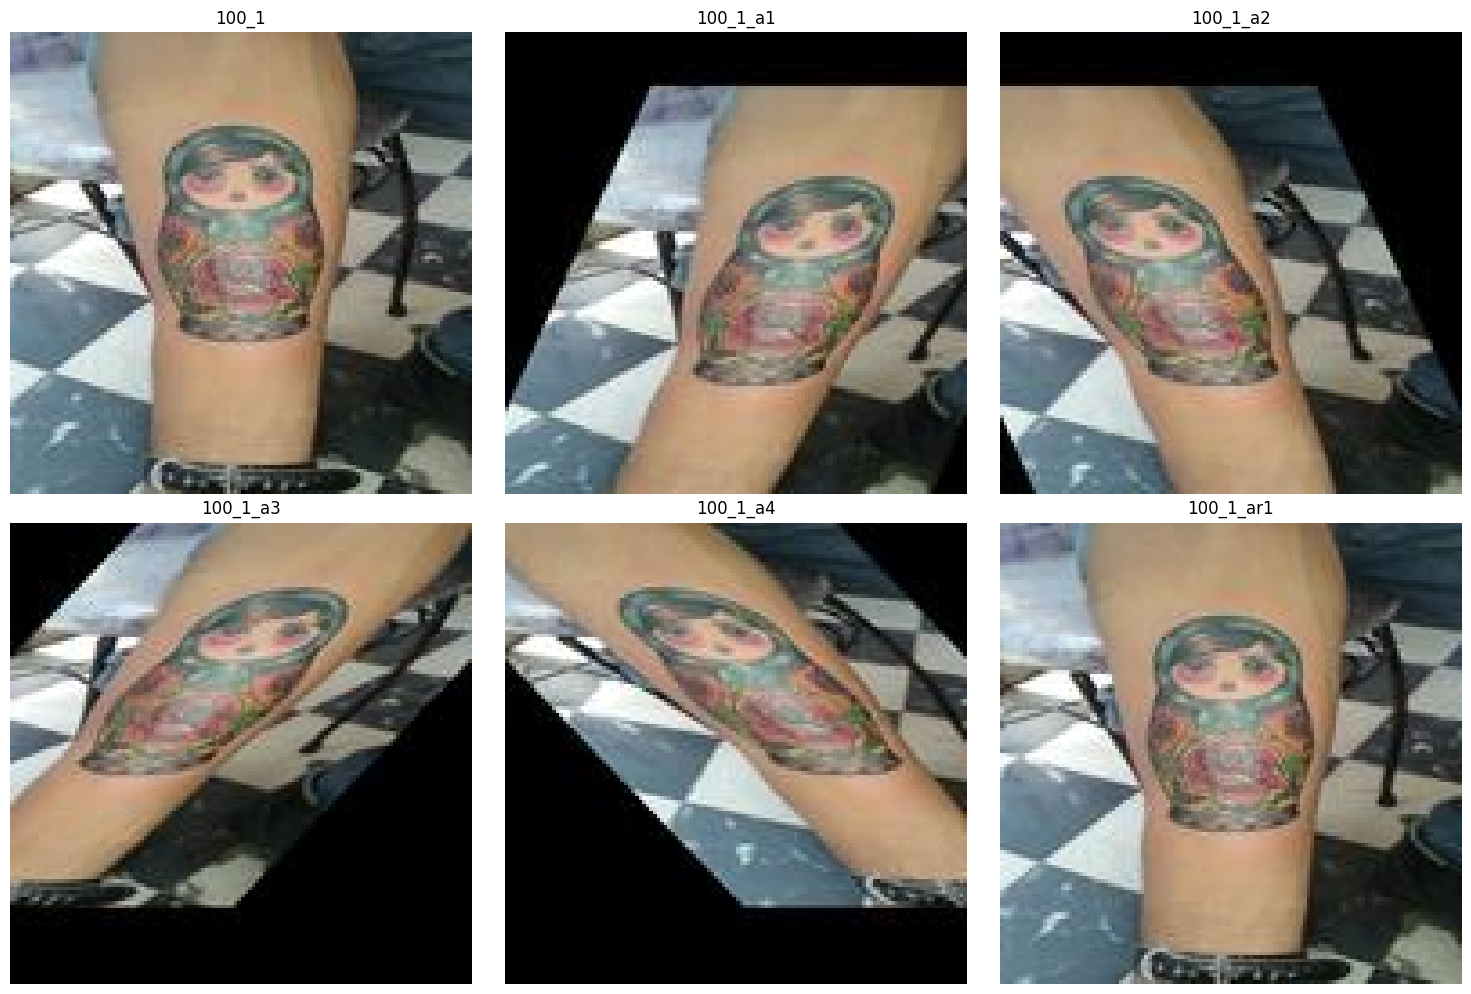

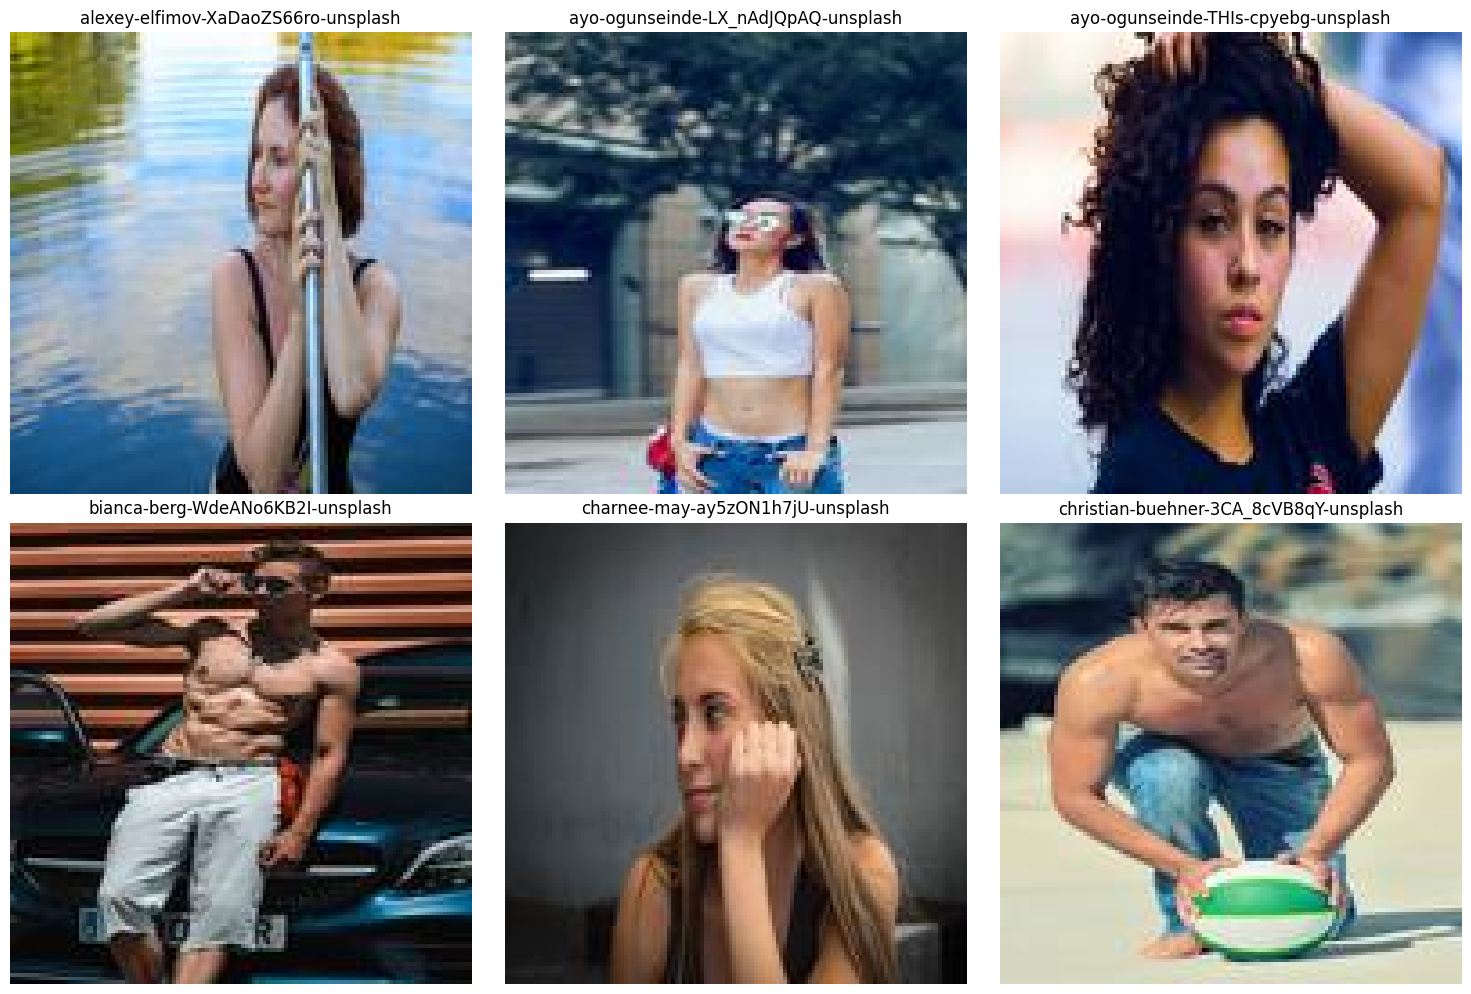

In [2]:
def display_images_with_labels(path, num_images=6):
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(min(num_images, len(image_files))):
        image_file = image_files[i]
        label = image_file.split('.')[0]

        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

path = "tattoo_dataset_r128/train/tattoo"
display_images_with_labels(path)

path = "tattoo_dataset_r128/train/no_tattoo"
display_images_with_labels(path)

## Procesamiento de Datos

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,      
    zoom_range=0.2,        
    horizontal_flip=True,   
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    r'tattoo_dataset_r128/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
     r'tattoo_dataset_r128/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
     r'tattoo_dataset_r128/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 3683 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Found 724 images belonging to 2 classes.


## Modelo de Deep Learning

In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),

    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator, 
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/100
116/116 [==============================] - 10s 79ms/step - loss: 0.1898 - accuracy: 0.9552 - val_loss: 0.1375 - val_accuracy: 0.9609
Epoch 2/100
116/116 [==============================] - 9s 73ms/step - loss: 0.1497 - accuracy: 0.9547 - val_loss: 0.1437 - val_accuracy: 0.9584
Epoch 3/100
116/116 [==============================] - 9s 74ms/step - loss: 0.1343 - accuracy: 0.9549 - val_loss: 0.0963 - val_accuracy: 0.9584
Epoch 4/100
116/116 [==============================] - 9s 76ms/step - loss: 0.1416 - accuracy: 0.9552 - val_loss: 0.1283 - val_accuracy: 0.9584
Epoch 5/100
116/116 [==============================] - 9s 75ms/step - loss: 0.1174 - accuracy: 0.9590 - val_loss: 0.0868 - val_accuracy: 0.9658
Epoch 6/100
116/116 [==============================] - 9s 75ms/step - loss: 0.1216 - accuracy: 0.9576 - val_loss: 0.0954 - val_accuracy: 0.9707
Epoch 7/100
116/116 [==============================] - 9s 74ms/step - loss: 0.1282 - accuracy: 0.9571 - val_loss: 0.0751 - val_accuracy

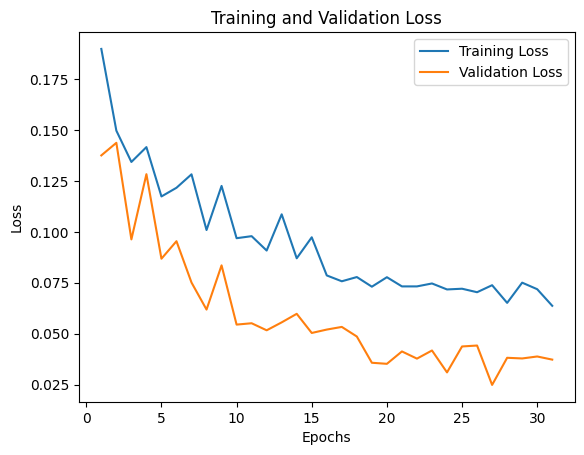

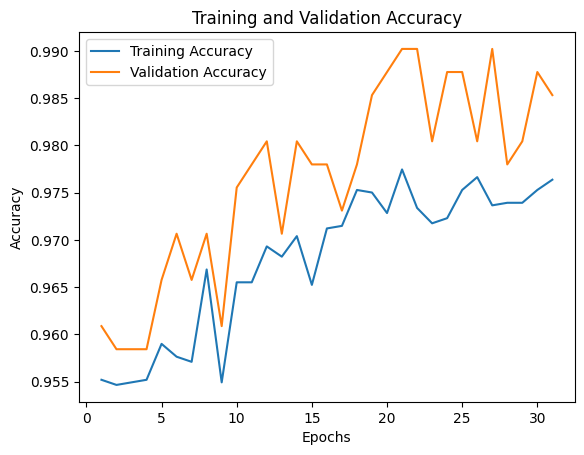

In [30]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
model.save("tattoo.keras")

In [7]:
model = tf.keras.models.load_model("tattoo.keras")

## Predicción y Evaluación

23/23 [==============================] - 5s 105ms/step - loss: 0.0654 - accuracy: 0.9738
Test Loss: 0.06538757681846619
Test Accuracy: 0.9737569093704224
23/23 [==============================] - 0s 16ms/step


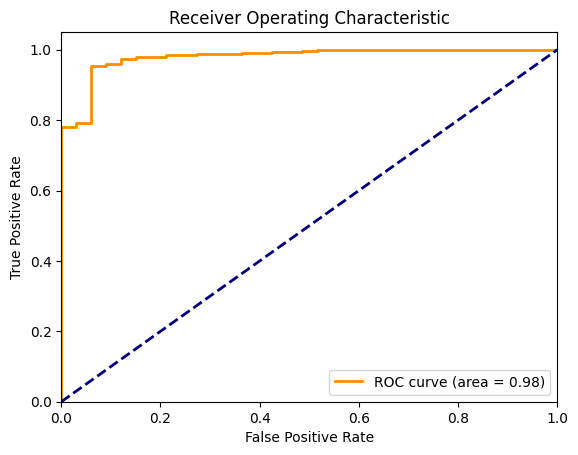

In [8]:
loss, accuracy = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

true_labels = test_generator.classes
predicted_probabilities = model.predict(test_generator)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Conclusión
En resumen, el modelo alcanzó una alta precisión (accuracy) tanto en los datos de entrenamiento como en los de validación, con valores que oscilaron alrededor del 97% en promedio. Durante las últimas épocas del entrenamiento la precisión en los datos de validación se mantuvo alta, alcanzando hasta un 99%, lo que indica que el modelo generalizó bien a datos no vistos. 

Basándonos en los resultados obtenidos, el modelo alcanzó una precisión (accuracy) del 97% en los datos de prueba, con una pérdida (loss) de aproximadamente 0.065 Estos resultados indican que el modelo generaliza bien a datos no vistos, ya que mantiene una alta precisión en los datos de prueba. Es importante destacar que la pérdida y la precisión obtenidas en los datos de prueba son consistentes con las métricas observadas durante el entrenamiento y validación del modelo, lo que sugiere que el modelo no ha sufrido de sobreajuste y que ha aprendido patrones generalizables de los datos de entrenamiento.